In this notebook, we'll be using a GRU model for a time series prediction task and we will compare the performance of the GRU model against an LSTM model as well. The dataset that we will be using is the Hourly Energy Consumption dataset which can be found on [Kaggle](https://www.kaggle.com/robikscube/hourly-energy-consumption). The dataset contains power consumption data across different regions around the United States recorded on an hourly basis.

You can run the code implementation in this article on FloydHub using their GPUs on the cloud by clicking the following link and using the main.ipynb notebook.

[![Run on FloydHub](https://static.floydhub.com/button/button-small.svg)](https://floydhub.com/run?template=https://github.com/gabrielloye/https://github.com/gabrielloye/GRU_Prediction)

This will speed up the training process significantly. Alternatively, the link to the GitHub repository can be found [here]().

The goal of this implementation is to create a model that can accurately predict the energy usage in the next hour given historical usage data. We will be using both the GRU and LSTM model to train on a set of historical data and evaluate both models on an unseen test set. To do so, we’ll start with feature selection, data-preprocessing, followed by defining, training and eventually evaluating the models.

We will be using the PyTorch library to implement both types of models along with other common Python libraries used in data analytics.

In [1]:
#https://www.python-engineer.com/posts/pytorch-rnn-lstm-gru/

#https://blog.floydhub.com/gru-with-pytorch/

import os
import time
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
from datetime import datetime

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler,QuantileTransformer
from sklearn.model_selection import train_test_split






### Local ###
#from data_processing import *



# Define data root directory

#data_dir = "./data/"
#print(os.listdir(data_dir))

We have a total of **12** *.csv* files containing hourly energy trend data (*'est_hourly.paruqet'* and *'pjm_hourly_est.csv'* are not used). In our next step, we will be reading these files and pre-processing these data in this order:
- Getting the time data of each individual time step and generalizing them
    - Hour of the day *i.e. 0-23*
    - Day of the week *i.e. 1-7*
    - Month *i.e. 1-12*
    - Day of the year *i.e. 1-365*
    
    
- Scale the data to values between 0 and 1
    - Algorithms tend to perform better or converge faster when features are on a relatively similar scale and/or close to normally distributed
    - Scaling preserves the shape of the original distribution and doesn't reduce the importance of outliers.
    
    
- Group the data into sequences to be used as inputs to the model and store their corresponding labels
    - The **sequence length** or **lookback period** is the number of data points in history that the model will use to make the prediction
    - The label will be the next data point in time after the last one in the input sequence
    

- The inputs and labels will then be split into training and test sets

In [2]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print(device)


def get_torch_device( v=0 ):
    # torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
    is_cuda = torch.cuda.is_available()
    # If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
    if is_cuda:
        device = torch.device("cuda")
        if v:  print( "CUDA Available!" )
    else:
        device = torch.device("cpu")
        if v:  print( "NO CUDA" )
    return device

cuda


In [7]:


#choppeddata_testset=pd.read_csv('choppeddata_10_04_2021_3Xcopiedsuccess.csv')#.head()
#choppeddata2=pd.read_csv('choppeddata_10_06_2021_3Xcopiedsuccess.csv')#.head()
#choppeddata3=pd.read_csv('choppeddata_10_13_2021_3Xcopiedsuccess.csv')#.head()


choppeddata1=pd.read_csv('choppeddata_10_04_2021_3Xcopiedsuccess.csv')#.head()

choppeddata2=pd.read_csv('choppeddata_10_06_2021_3Xcopiedsuccess.csv')#.head()
choppeddata3=pd.read_csv('choppeddata_10_13_2021_3Xcopiedsuccess.csv')#.head()

#choppeddata1=pd.read_csv('choppeddata_10_04_2021_randomselector_even.csv')#.head()
#choppeddata2=pd.read_csv('choppeddata_10_06_2021_randomselector_even.csv')#.head()
#choppeddata3=pd.read_csv('choppeddata_10_13_2021_randomselector_even.csv')#.head()



choppeddata_testset1=pd.read_csv('choppeddata_10_23_2021_3Xcopiedsuccess_fromGRUlookahead.csv')#.head()
choppeddata_testset2=pd.read_csv('choppeddata_10_23_2021_3Xcopiedsuccess_fromGRUlookahead_pos2rewardifbuttonpress.csv')#.head()




#print(choppeddata1.shape)
print(choppeddata2.shape)
print(choppeddata3.shape)
#frames = [choppeddata1, choppeddata2,choppeddata3]
frames = [choppeddata1,choppeddata2,choppeddata3]
choppeddata = pd.concat(frames)

frames2 = [choppeddata_testset1,choppeddata_testset2]
choppeddata_testset = pd.concat(frames2)



print("contatenated data size:")
print(choppeddata.shape)

print("contatenated data testset size:")
print(choppeddata_testset.shape)

(31320, 10)
(44100, 10)
contatenated data size:
(99684, 10)
contatenated data testset size:
(1872, 10)


In [10]:
print(choppeddata.shape)
runqty=int(choppeddata.shape[0]/6)
print("total runs:",runqty)
choppedheaders=[]
lookback=10 #save only the last 11 timesteps
for i in range(lookback):  
    label=str(i)
    choppedheaders.append("header"+label)

#put chopped data in np.arrays
State=np.zeros((runqty,5,lookback)) #96 runs,with 5 sets of data (x,y,z,roll,pitch) each, and each run is 11 timesteps long
Labels=np.zeros((runqty,lookback)) #96 runs, each run is 11 timesteps long
runcounter=0

for i in range(0,choppeddata.shape[0],6):
            State[runcounter][0][:]=(choppeddata[choppedheaders[:]].iloc[i]).tolist()
            State[runcounter][1][:]=(choppeddata[choppedheaders[:]].iloc[i+1]).tolist()
            State[runcounter][2][:]=(choppeddata[choppedheaders[:]].iloc[i+2]).tolist()
            State[runcounter][3][:]=(choppeddata[choppedheaders[:]].iloc[i+3]).tolist()
            State[runcounter][4][:]=(choppeddata[choppedheaders[:]].iloc[i+4]).tolist()
            Labels[runcounter][:]=(choppeddata[choppedheaders[:]].iloc[i+5]).tolist()  #labels   
            runcounter+=1
#print(State[0])
#print(Labels)
#print(Labels[:,9]) #just getting finals labels

print(State.shape)
print(Labels.shape)




(99684, 10)
total runs: 16614
(16614, 5, 10)
(16614, 10)


In [11]:
#make test set with data outside of training set, because of duplication of successful runs. 


print(choppeddata_testset.shape)
runqty_testset=int(choppeddata_testset.shape[0]/6)
print("total runs:",runqty_testset)

#put chopped data in np.arrays
State_testset=np.zeros((runqty_testset,5,lookback)) #96 runs,with 5 sets of data (x,y,z,roll,pitch) each, and each run is 11 timesteps long
Labels_testset=np.zeros((runqty_testset,lookback)) #96 runs, each run is 11 timesteps long
runcounter=0

for i in range(0,choppeddata_testset.shape[0],6):
            State_testset[runcounter][0][:]=(choppeddata_testset[choppedheaders[:]].iloc[i]).tolist()
            State_testset[runcounter][1][:]=(choppeddata_testset[choppedheaders[:]].iloc[i+1]).tolist()
            State_testset[runcounter][2][:]=(choppeddata_testset[choppedheaders[:]].iloc[i+2]).tolist()
            State_testset[runcounter][3][:]=(choppeddata_testset[choppedheaders[:]].iloc[i+3]).tolist()
            State_testset[runcounter][4][:]=(choppeddata_testset[choppedheaders[:]].iloc[i+4]).tolist()
            Labels_testset[runcounter][:]=(choppeddata_testset[choppedheaders[:]].iloc[i+5]).tolist()  #labels   
            runcounter+=1

print(State_testset.shape)
print(Labels_testset.shape)           

(1872, 10)
total runs: 312
(312, 5, 10)
(312, 10)


In [12]:
#X= range(0,575,6)
#y= range(0,575,6)

X=State[:,:,0:9]

y=Labels[:,lookback-1]  #Get only the last data in the row: Row normally looks like: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
print("x.shape",X.shape)

y=y.reshape(runqty,1)

random_seed=int(time.time())
#print(int(time.time()))
train_x, test_x, train_y,test_y = train_test_split(X, y, test_size= float(.00001),#.25 #0.33, 
                                                   random_state=random_seed)
#print("Train")
#print(train_x[0])
#print(train_y[0])
print("Test set X size", train_x.shape)
print("Train set Y size", train_y.shape)
#print(test_x[0])
#print(test_y[0])
print("Test set X size", test_x.shape)
print("Test set Y size", test_y.shape)

x.shape (16614, 5, 9)
Test set X size (16613, 5, 9)
Train set Y size (16613, 1)
Test set X size (1, 5, 9)
Test set Y size (1, 1)


In [15]:
#X= range(0,575,6)
#y= range(0,575,6)

X_testset=State_testset[:,:,0:9]
y_testset=Labels_testset[:,lookback-1]
print("x.shape",X_testset.shape)

y_testset=y_testset.reshape(runqty_testset,1)

random_seed=int(time.time())
#print(int(time.time()))
train_x_testset, test_x_testset, train_y_testset,test_y_testset = train_test_split(X_testset, y_testset, test_size=.995,#.25 #0.33, 
                                                   random_state=random_seed)
#print("Train")
#print(train_x[0])
#print(train_y[0])
print("Test set X size", train_x_testset.shape)
print("Train set Y size", train_y_testset.shape)
#print(test_x[0])
#print(test_y[0])
print("Test set X size", test_x_testset.shape)
print("Test set Y size", test_y_testset.shape)

x.shape (312, 5, 9)
Test set X size (1, 5, 9)
Train set Y size (1, 1)
Test set X size (311, 5, 9)
Test set Y size (311, 1)


We have a total of 980,185 sequences of training data

To improve the speed of our training, we can process the data in batches so that the model does not need to update its weights as frequently. The Torch *Dataset* and *DataLoader* classes are useful for splitting our data into batches and shuffling them.

We can also check if we have any GPUs to speed up our training time by many folds. If you’re using FloydHub with GPU to run this code, the training time will be significantly reduced.

In [5]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden
def train(train_loader, learn_rate, hidden_dim=128, EPOCHS=400, model_type="GRU"):
    #got  109 / 180 on training set, 29 / 60 on test set from 128 hidden dim, 50 epoch, batch size of 4, lr =0.001
    #Got training data= 146 / 180, success vs test data= 38 / 60 with same as above but 100 epoch
    #Got training data= 172 / 180, success vs test data= 46 / 60 with same as above but 200 epoch
    #Got training data= 165 / 180, success vs test data= 52 / 60 with same as above but 200 epoch
    
    losslist=[]
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]  #  = 11
    #print(input_dim)
    #print("input_dim",input_dim)
    output_dim = 1
    n_layers = 2
    # Instantiating the models
    if model_type == "GRU":
        model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    else:
        model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)
    
    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.clock()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            #print("x",x)
            #print("label",label)
            counter += 1
            if model_type == "GRU":
                h = h.data
            else:
                h = tuple([e.data for e in h])
            model.zero_grad()
            
            out, h = model(x.to(device).float(), h)
            #print("out",out)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            
            if counter%20000 == 0:
                print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.clock()
        if epoch%40 == 0:
            print("Epoch {}/{} Done, Total Loss: {}   Time Elapsed: {} seconds".format(epoch, EPOCHS, avg_loss/len(train_loader),str(current_time-start_time)))
        
            #print("Total".format())
        losslist.append(avg_loss/len(train_loader))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    plt.plot(losslist)
    plt.title("Loss")
    plt.show()
    return model,losslist

def train_existing_model(model,train_loader, learn_rate, hidden_dim=128, EPOCHS=400, model_type="GRU"):
    #got  109 / 180 on training set, 29 / 60 on test set from 128 hidden dim, 50 epoch, batch size of 4, lr =0.001
    #Got training data= 146 / 180, success vs test data= 38 / 60 with same as above but 100 epoch
    #Got training data= 172 / 180, success vs test data= 46 / 60 with same as above but 200 epoch
    #Got training data= 165 / 180, success vs test data= 52 / 60 with same as above but 200 epoch
    
    losslist=[]
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]  #  = 11
    #print(input_dim)
    #print("input_dim",input_dim)
    output_dim = 1
    n_layers = 2
    # Instantiating the models
    """
    if model_type == "GRU":
        model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    else:
        model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
    """    
        
    model.to(device)
    
    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.clock()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            #print("x",x)
            #print("label",label)
            counter += 1
            if model_type == "GRU":
                h = h.data
            else:
                h = tuple([e.data for e in h])
            model.zero_grad()
            
            out, h = model(x.to(device).float(), h)
            #print("out",out)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            
            if counter%20000 == 0:
                print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.clock()
        if epoch%40 == 0:
            print("Epoch {}/{} Done, Total Loss: {}   Time Elapsed: {} seconds".format(epoch, EPOCHS, avg_loss/len(train_loader),str(current_time-start_time)))
        
            #print("Total".format())
        losslist.append(avg_loss/len(train_loader))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    plt.plot(losslist)
    plt.title("Loss")
    plt.show()
    return model,losslist


def evaluate(model, test_x, test_y):
    model.eval()
    outputs = []
    targets = []
    start_time = time.clock()
    #for i in test_x.keys():
    for i in range( len( test_x ) ):    
        inp = torch.from_numpy(np.array(test_x[i])) # should be 5x1
        labs = torch.from_numpy(np.array(test_y[i])) #should be 1x1
        h = model.init_hidden(inp.shape[0])
        #print("inp",inp)
        #print("labs",labs)
        #print("h",h)
        out, h = model(inp.to(device).float(), h)
        #outputs.append(label_scalers[i].inverse_transform(out.cpu().detach().numpy()).reshape(-1))
        #targets.append(label_scalers[i].inverse_transform(labs.numpy()).reshape(-1))
        outputs.append( out.cpu().detach().numpy().reshape(-1) )
        targets.append( labs.numpy().reshape(-1) )
        
    print("Evaluation Time: {}".format(str(time.clock()-start_time)))
    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets, sMAPE
                               
def evaluate2(model, test_x, test_y):
    model.eval()
    outputs = []
    targets = []  #labels
    #start_time = time.clock()
    #for i in test_x.keys():
    #for i in range( len( test_x ) ):    
    inp = torch.from_numpy(np.array(test_x)) # should be 5x1
    labs = torch.from_numpy(np.array(test_y)) #should be 1x1
    h = model.init_hidden(inp.shape[0])
    #print("inp",inp)
    #print("labs",labs)
    #print("h",h)
    out, h = model(inp.to(device).float(), h)
    #outputs.append(label_scalers[i].inverse_transform(out.cpu().detach().numpy()).reshape(-1))
    #targets.append(label_scalers[i].inverse_transform(labs.numpy()).reshape(-1))
    outputs.append( out.cpu().detach().numpy().reshape(-1) )
    targets.append( labs.numpy().reshape(-1) )
        
    #print("Evaluation Time: {}".format(str(time.clock()-start_time)))
    sMAPE = 0
    #for i in range(len(outputs)):
    #    sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    #print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets#, sMAPE                               

def evaluatefull_maxdiff(model, train_x, train_y, test_x, test_y,maxdifference=0.2, verbose=False):

    #m = nn.ReLU()
    #m = nn.Sigmoid()
    #output = m(input)
    print("Vs Training Set")
    gru_outputs, targets, gru_sMAPE = evaluate2(gru_model, train_x, train_y)
    #print(test_y)
    #print(gru_outputs)
    #print(gru_outputs[0][5])


    testy=test_y.reshape(-1)
    trainy=train_y.reshape(-1)


    #print("Train size:",trainy.size)
    print(gru_outputs[0][4])
    train_successcounter=0
    for i in range(int(trainy.size)):
        #print(testy[i],gru_outputs[0][i],m(torch.tensor(gru_outputs[0][i])))
        #print(train[i],gru_outputs[0][i],m(torch.tensor(gru_outputs[0][i])))


        #print(trainy[i],gru_outputs[0][i], m(torch.tensor(gru_outputs[0][i])))


        if abs(trainy[i]-gru_outputs[0][i])<maxdifference :
            train_successcounter+=1
        #print(testy[i])
        #print
        #output = m(input)



    test_successcounter=0
    print("Vs Test Set")
    gru_outputs, targets, gru_sMAPE = evaluate2(gru_model, test_x, test_y)
    #print("test size: ",testy.size)

    for i in range(int(testy.size)):


        #, m(torch.tensor(gru_outputs[0][i])))


        if abs(testy[i]-gru_outputs[0][i])<maxdifference :
            test_successcounter+=1
            if verbose==True:
                print(testy[i],gru_outputs[0][i], "OK" )
        else:
            if verbose==True:
                print(testy[i],gru_outputs[0][i], "X" )
            #print(testy[i])
        #print
        #output = m(input)
    print("")
    print(" vs training data=" ,train_successcounter,"/",trainy.size, " vs test data=" ,
          test_successcounter,"/",testy.size,int(100*test_successcounter/testy.size),"%", "at max difference",maxdifference )
    return ( train_successcounter ,test_successcounter)


def evaluatefull_cutoff(gru_model, train_x, train_y, test_x, test_y,cutoff=0.5, verbose=False):

    #m = nn.ReLU()
    #m = nn.Sigmoid()
    #output = m(input)
    
    #gru_outputs, targets, gru_sMAPE = evaluate2(gru_model, train_x, train_y)
    gru_outputs, targets= evaluate2(gru_model, train_x, train_y)
    #print(test_y)
    #print(gru_outputs)
    #print(gru_outputs[0][5])


    testy=test_y.reshape(-1)
    trainy=train_y.reshape(-1)
    #print("Vs Training Set")
    #print(gru_outputs[0][4])
    traincounter_falsenegative=0
    traincounter_falsepositive=0
    
    traincounter_truenegative=0
    traincounter_truepositive=0
    for i in range(int(trainy.size)):
        
        if trainy[i]==1  and gru_outputs[0][i]>= cutoff:
            traincounter_truepositive+=1
            if verbose==True:
                print(trainy[i],gru_outputs[0][i], "OK-truepositive" )
        elif trainy[i]==1  and gru_outputs[0][i]< cutoff:
            traincounter_falsenegative+=1
            if verbose==True:
                print(trainy[i],gru_outputs[0][i], "X-falsenegative" )       
                
        elif trainy[i]==0 and gru_outputs[0][i]<= cutoff :
            traincounter_truenegative+=1
            if verbose==True:
                print(trainy[i],gru_outputs[0][i], "OK-truenegative" )           
        elif trainy[i]==0 and gru_outputs[0][i]> cutoff:
            traincounter_falsepositive+=1
            if verbose==True:
                print(trainy[i],gru_outputs[0][i], "X-falsepositive" )     
                
           
    #print("TRAINING SET: Fails for button not pressed:",  train_failzerocounter,"Fails for button pressed:", train_failonecounter )        
    test_successcounter=0
    test_failzerocounter=0
    test_failonecounter=0
    
    #gru_outputs, targets, gru_sMAPE = evaluate2(gru_model, test_x, test_y)
    gru_outputs, targets = evaluate2(gru_model, test_x, test_y)
    #print("Vs Test Set")
    #print(gru_outputs[0][4])
    #print("test size: ",testy.size)


    testcounter_falsenegative=0
    testcounter_falsepositive=0
    
    testcounter_truenegative=0
    testcounter_truepositive=0
    for i in range(int(testy.size)):
        
        if testy[i]==1  and gru_outputs[0][i]>= cutoff:
            testcounter_truepositive+=1
            if verbose==True:
                print(testy[i],gru_outputs[0][i], "OK-truepositive" )
        elif testy[i]==1  and gru_outputs[0][i]< cutoff:
            testcounter_falsenegative+=1
            if verbose==True:
                print(testy[i],gru_outputs[0][i], "X-falsenegative" )       
                
        elif testy[i]==0 and gru_outputs[0][i]<= cutoff :
            testcounter_truenegative+=1
            if verbose==True:
                print(testy[i],gru_outputs[0][i], "OK-truenegative" )           
        elif testy[i]==0 and gru_outputs[0][i]> cutoff:
            testcounter_falsepositive+=1
            if verbose==True:
                print(testy[i],gru_outputs[0][i], "X-falsepositive" )   
    
    print(" vs training data=" ,traincounter_truepositive+traincounter_truenegative,"/",trainy.size, " vs test data=" ,
          testcounter_truepositive+testcounter_truenegative,"/",testy.size,round((100*(testcounter_truepositive+testcounter_truenegative)/testy.size),2),"%", "at cutoff",cutoff )
    
    
    print("TEST SET: True Positives",testcounter_truepositive,"True Negatives", testcounter_truenegative," False Positives",testcounter_falsepositive,"False Negatives", testcounter_falsenegative)
    print("")
    return ( traincounter_truepositive+traincounter_truenegative, testcounter_truepositive+testcounter_truenegative)


x.shape (16614, 5, 9)
x.shape (312, 5, 9)
Starting Training of GRU model


/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Epoch 40/600 Done, Total Loss: 0.13463141982044494   Time Elapsed: 0.6409830000000056 seconds
Epoch 80/600 Done, Total Loss: 0.10560374225140999   Time Elapsed: 0.6110740000000021 seconds
Epoch 120/600 Done, Total Loss: 0.08249933540130674   Time Elapsed: 0.6240980000000036 seconds
Epoch 160/600 Done, Total Loss: 0.06442533685146151   Time Elapsed: 0.600970000000018 seconds
Epoch 200/600 Done, Total Loss: 0.052140525984487936   Time Elapsed: 0.6183309999999551 seconds
Epoch 240/600 Done, Total Loss: 0.041658315074029575   Time Elapsed: 0.5947380000000067 seconds
Epoch 280/600 Done, Total Loss: 0.03682302132709146   Time Elapsed: 0.6011169999999879 seconds
Epoch 320/600 Done, Total Loss: 0.03149728598181   Time Elapsed: 0.6242340000000013 seconds
Epoch 360/600 Done, Total Loss: 0.02848402030305743   Time Elapsed: 0.6210470000000328 seconds
Epoch 400/600 Done, Total Loss: 0.024510294918157878   Time Elapsed: 0.6184220000000096 seconds
Epoch 440/600 Done, Total Loss: 0.023058194922405552 

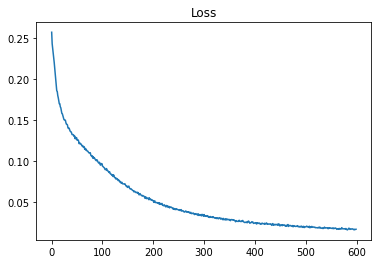

 vs training data= 15107 / 16613  vs test data= 258 / 311 82.96 % at cutoff 0.1
TEST SET: True Positives 150 True Negatives 108  False Positives 47 False Negatives 6

 vs training data= 16173 / 16613  vs test data= 268 / 311 86.17 % at cutoff 0.2
TEST SET: True Positives 144 True Negatives 124  False Positives 31 False Negatives 12

 vs training data= 16430 / 16613  vs test data= 268 / 311 86.17 % at cutoff 0.3
TEST SET: True Positives 138 True Negatives 130  False Positives 25 False Negatives 18

 vs training data= 16535 / 16613  vs test data= 273 / 311 87.78 % at cutoff 0.4
TEST SET: True Positives 138 True Negatives 135  False Positives 20 False Negatives 18

 vs training data= 16567 / 16613  vs test data= 271 / 311 87.14 % at cutoff 0.5
TEST SET: True Positives 132 True Negatives 139  False Positives 16 False Negatives 24

 vs training data= 16587 / 16613  vs test data= 275 / 311 88.42 % at cutoff 0.6
TEST SET: True Positives 132 True Negatives 143  False Positives 12 False Negativ

/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:117: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:140: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Epoch 40/200 Done, Total Loss: 0.016282319177560595   Time Elapsed: 0.6134410000000798 seconds
Epoch 80/200 Done, Total Loss: 0.015122486664967532   Time Elapsed: 0.677477999999951 seconds
Epoch 120/200 Done, Total Loss: 0.014586017760142511   Time Elapsed: 0.6223089999999729 seconds
Epoch 160/200 Done, Total Loss: 0.01332803294026656   Time Elapsed: 0.6431239999999434 seconds
Epoch 200/200 Done, Total Loss: 0.01295657452684917   Time Elapsed: 0.6250769999999193 seconds
Total Training Time: 124.12026799999956 seconds


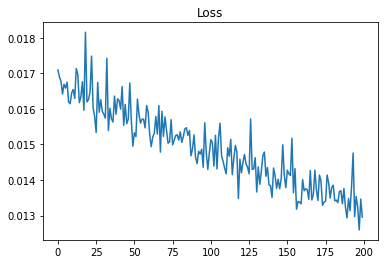

 vs training data= 15845 / 16613  vs test data= 261 / 311 83.92 % at cutoff 0.1
TEST SET: True Positives 150 True Negatives 111  False Positives 44 False Negatives 6

 vs training data= 16434 / 16613  vs test data= 269 / 311 86.5 % at cutoff 0.2
TEST SET: True Positives 144 True Negatives 125  False Positives 30 False Negatives 12

 vs training data= 16546 / 16613  vs test data= 272 / 311 87.46 % at cutoff 0.3
TEST SET: True Positives 138 True Negatives 134  False Positives 21 False Negatives 18

 vs training data= 16585 / 16613  vs test data= 278 / 311 89.39 % at cutoff 0.4
TEST SET: True Positives 138 True Negatives 140  False Positives 15 False Negatives 18

 vs training data= 16604 / 16613  vs test data= 268 / 311 86.17 % at cutoff 0.5
TEST SET: True Positives 126 True Negatives 142  False Positives 13 False Negatives 30

 vs training data= 16611 / 16613  vs test data= 271 / 311 87.14 % at cutoff 0.6
TEST SET: True Positives 126 True Negatives 145  False Positives 10 False Negative

'\ngru_model3, losslist3 =train_existing_model(gru_model2,train_loader, lr , hidden_dim=128, EPOCHS=200, model_type="GRU")\ntrain2 ,test2=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=.4)\ntrain2 ,test2=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=.5)\ntrain3 ,test3=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=.6)\ntrain4 ,test4=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=.7)\n\n\ngru_model4, losslist4 =train_existing_model(gru_model3,train_loader, lr , hidden_dim=128, EPOCHS=200, model_type="GRU")\n\ntrain2 ,test2=evaluatefull_cutoff(gru_model4, train_x, train_y, test_x, test_y,cutoff=.4)\ntrain2 ,test2=evaluatefull_cutoff(gru_model4, train_x, train_y, test_x, test_y,cutoff=.5)\ntrain3 ,test3=evaluatefull_cutoff(gru_model4, train_x, train_y, test_x, test_y,cutoff=.6)\ntrain4 ,test4=evaluatefull_cutoff(gru_model4, train_x, train_y, test_x, test_y,cutoff=.7)\n\ngru_model5, losslis

In [18]:
lr = 0.0005
batch_size = 64
#a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

X=State[:,:,0:9]
y=Labels[:,lookback-1]
print("x.shape",X.shape)
y=y.reshape(runqty,1)


X_testset=State_testset[:,:,0:9]
y_testset=Labels_testset[:,lookback-1]
print("x.shape",X_testset.shape)

y_testset=y_testset.reshape(runqty_testset,1)


random_seed=int(time.time())
#print(int(time.time()))
train_x_trainset, test_x_trainset, train_y_trainset,test_y_trainset = train_test_split(X, y, test_size= float(.00001),#.25 #0.33, 
                                                   random_state=random_seed)

train_x_testset, test_x_testset, train_y_testset,test_y_testset = train_test_split(X_testset, y_testset, test_size=.995,#.25 #0.33, 
                                                   random_state=random_seed)

train_data = TensorDataset(torch.from_numpy(train_x_trainset), torch.from_numpy(train_y_trainset))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

test_data   = TensorDataset( torch.from_numpy( test_x_testset ), torch.from_numpy( test_y_testset) )
test_loader = DataLoader( test_data, shuffle = True, batch_size = batch_size, drop_last = True )




gru_model1, losslist1 =train(train_loader, lr , hidden_dim=128, EPOCHS=600 ,model_type="GRU") #1500  #had low total loss with batch size 32
train2 ,test2=evaluatefull_cutoff(gru_model1, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.1)
train2 ,test2=evaluatefull_cutoff(gru_model1, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.2)
train3 ,test3=evaluatefull_cutoff(gru_model1, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.3)
train2 ,test2=evaluatefull_cutoff(gru_model1, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.4)
train2 ,test2=evaluatefull_cutoff(gru_model1, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.5)
train3 ,test3=evaluatefull_cutoff(gru_model1, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.6)
train4 ,test4=evaluatefull_cutoff(gru_model1, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.7)
train4 ,test4=evaluatefull_cutoff(gru_model1, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.8)
train4 ,test4=evaluatefull_cutoff(gru_model1, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.9)


gru_model2, losslist2 =train_existing_model(gru_model1,train_loader, lr , hidden_dim=128, EPOCHS=200, model_type="GRU")

train2 ,test2=evaluatefull_cutoff(gru_model2, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.1)
train2 ,test2=evaluatefull_cutoff(gru_model2, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.2)
train3 ,test3=evaluatefull_cutoff(gru_model2, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.3)
train2 ,test2=evaluatefull_cutoff(gru_model2, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.4)
train2 ,test2=evaluatefull_cutoff(gru_model2, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.5)
train3 ,test3=evaluatefull_cutoff(gru_model2, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.6)
train4 ,test4=evaluatefull_cutoff(gru_model2, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.7)
train4 ,test4=evaluatefull_cutoff(gru_model2, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.8)
train4 ,test4=evaluatefull_cutoff(gru_model2, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.9)
"""
gru_model3, losslist3 =train_existing_model(gru_model2,train_loader, lr , hidden_dim=128, EPOCHS=200, model_type="GRU")
train2 ,test2=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=.4)
train2 ,test2=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=.5)
train3 ,test3=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=.6)
train4 ,test4=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=.7)


gru_model4, losslist4 =train_existing_model(gru_model3,train_loader, lr , hidden_dim=128, EPOCHS=200, model_type="GRU")

train2 ,test2=evaluatefull_cutoff(gru_model4, train_x, train_y, test_x, test_y,cutoff=.4)
train2 ,test2=evaluatefull_cutoff(gru_model4, train_x, train_y, test_x, test_y,cutoff=.5)
train3 ,test3=evaluatefull_cutoff(gru_model4, train_x, train_y, test_x, test_y,cutoff=.6)
train4 ,test4=evaluatefull_cutoff(gru_model4, train_x, train_y, test_x, test_y,cutoff=.7)

gru_model5, losslist5 =train_existing_model(gru_model4,train_loader, lr , hidden_dim=128, EPOCHS=200, model_type="GRU")
train2 ,test2=evaluatefull_cutoff(gru_model5, train_x, train_y, test_x, test_y,cutoff=.4)
train2 ,test2=evaluatefull_cutoff(gru_model5, train_x, train_y, test_x, test_y,cutoff=.5)
train3 ,test3=evaluatefull_cutoff(gru_model5, train_x, train_y, test_x, test_y,cutoff=.6)
train4 ,test4=evaluatefull_cutoff(gru_model5, train_x, train_y, test_x, test_y,cutoff=.7)

gru_model6, losslist6 =train_existing_model(gru_model5,train_loader, lr , hidden_dim=128, EPOCHS=200, model_type="GRU")
train2 ,test2=evaluatefull_cutoff(gru_model6, train_x, train_y, test_x, test_y,cutoff=.4)
train2 ,test2=evaluatefull_cutoff(gru_model6, train_x, train_y, test_x, test_y,cutoff=.5)
train3 ,test3=evaluatefull_cutoff(gru_model6, train_x, train_y, test_x, test_y,cutoff=.6)
train4 ,test4=evaluatefull_cutoff(gru_model6, train_x, train_y, test_x, test_y,cutoff=.7)

gru_model7, losslist7 =train_existing_model(gru_model6,train_loader, lr , hidden_dim=128, EPOCHS=200, model_type="GRU")
train2 ,test2=evaluatefull_cutoff(gru_model7, train_x, train_y, test_x, test_y,cutoff=.4)
train2 ,test2=evaluatefull_cutoff(gru_model7, train_x, train_y, test_x, test_y,cutoff=.5)
train3 ,test3=evaluatefull_cutoff(gru_model7, train_x, train_y, test_x, test_y,cutoff=.6)
train4 ,test4=evaluatefull_cutoff(gru_model7, train_x, train_y, test_x, test_y,cutoff=.7)

gru_model8, losslist8 =train_existing_model(gru_model7,train_loader, lr , hidden_dim=128, EPOCHS=200, model_type="GRU")
train2 ,test2=evaluatefull_cutoff(gru_model8, train_x, train_y, test_x, test_y,cutoff=.4)
train2 ,test2=evaluatefull_cutoff(gru_model8, train_x, train_y, test_x, test_y,cutoff=.5)
train3 ,test3=evaluatefull_cutoff(gru_model8, train_x, train_y, test_x, test_y,cutoff=.6)
train4 ,test4=evaluatefull_cutoff(gru_model8, train_x, train_y, test_x, test_y,cutoff=.7)

fulllosslist=losslist1+losslist2+losslist3+losslist4+losslist5+losslist6+losslist7+losslist8
plt.plot(fulllosslist)
plt.title("Loss")
plt.show()
"""

Starting Training of GRU model


/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:117: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:140: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Epoch 40/200 Done, Total Loss: 0.012950964387089129   Time Elapsed: 0.6317070000000058 seconds
Epoch 80/200 Done, Total Loss: 0.012051674756706912   Time Elapsed: 0.6249290000000656 seconds
Epoch 120/200 Done, Total Loss: 0.011828021254232261   Time Elapsed: 0.6325530000000299 seconds
Epoch 160/200 Done, Total Loss: 0.011414316475650289   Time Elapsed: 0.6122450000000299 seconds
Epoch 200/200 Done, Total Loss: 0.010278379073560698   Time Elapsed: 0.6323079999999663 seconds
Total Training Time: 125.74571600000047 seconds


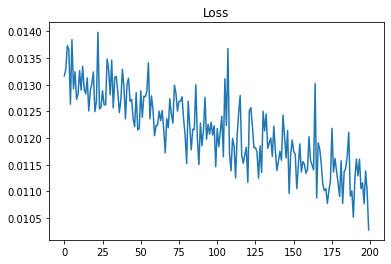

 vs training data= 15685 / 16613  vs test data= 1 / 1 100.0 % at cutoff 0.1
TEST SET: True Positives 0 True Negatives 1  False Positives 0 False Negatives 0

 vs training data= 16354 / 16613  vs test data= 1 / 1 100.0 % at cutoff 0.2
TEST SET: True Positives 0 True Negatives 1  False Positives 0 False Negatives 0

 vs training data= 16498 / 16613  vs test data= 1 / 1 100.0 % at cutoff 0.3
TEST SET: True Positives 0 True Negatives 1  False Positives 0 False Negatives 0

 vs training data= 16561 / 16613  vs test data= 1 / 1 100.0 % at cutoff 0.4
TEST SET: True Positives 0 True Negatives 1  False Positives 0 False Negatives 0

 vs training data= 16588 / 16613  vs test data= 1 / 1 100.0 % at cutoff 0.5
TEST SET: True Positives 0 True Negatives 1  False Positives 0 False Negatives 0

 vs training data= 16605 / 16613  vs test data= 1 / 1 100.0 % at cutoff 0.6
TEST SET: True Positives 0 True Negatives 1  False Positives 0 False Negatives 0

 vs training data= 16600 / 16613  vs test data= 1 / 

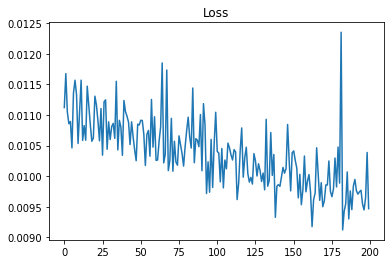

 vs training data= 16149 / 16613  vs test data= 1 / 1 100.0 % at cutoff 0.1
TEST SET: True Positives 0 True Negatives 1  False Positives 0 False Negatives 0

 vs training data= 16551 / 16613  vs test data= 1 / 1 100.0 % at cutoff 0.2
TEST SET: True Positives 0 True Negatives 1  False Positives 0 False Negatives 0

 vs training data= 16597 / 16613  vs test data= 1 / 1 100.0 % at cutoff 0.3
TEST SET: True Positives 0 True Negatives 1  False Positives 0 False Negatives 0

 vs training data= 16609 / 16613  vs test data= 1 / 1 100.0 % at cutoff 0.4
TEST SET: True Positives 0 True Negatives 1  False Positives 0 False Negatives 0

 vs training data= 16612 / 16613  vs test data= 1 / 1 100.0 % at cutoff 0.5
TEST SET: True Positives 0 True Negatives 1  False Positives 0 False Negatives 0

 vs training data= 16610 / 16613  vs test data= 1 / 1 100.0 % at cutoff 0.6
TEST SET: True Positives 0 True Negatives 1  False Positives 0 False Negatives 0

 vs training data= 16610 / 16613  vs test data= 1 / 

In [19]:
gru_model3, losslist3 =train_existing_model(gru_model2,train_loader, lr , hidden_dim=128, EPOCHS=200, model_type="GRU")
train2 ,test2=evaluatefull_cutoff(gru_model3, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.1)
train2 ,test2=evaluatefull_cutoff(gru_model3, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.2)
train3 ,test3=evaluatefull_cutoff(gru_model3, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.3)
train2 ,test2=evaluatefull_cutoff(gru_model3, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.4)
train2 ,test2=evaluatefull_cutoff(gru_model3, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.5)
train3 ,test3=evaluatefull_cutoff(gru_model3, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.6)
train4 ,test4=evaluatefull_cutoff(gru_model3, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.7)
train4 ,test4=evaluatefull_cutoff(gru_model3, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.8)
train4 ,test4=evaluatefull_cutoff(gru_model3, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.9)


print("")
print("")


gru_model4, losslist4 =train_existing_model(gru_model3,train_loader, lr , hidden_dim=128, EPOCHS=200, model_type="GRU")
train2 ,test2=evaluatefull_cutoff(gru_model4, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.1)
train2 ,test2=evaluatefull_cutoff(gru_model4, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.2)
train3 ,test3=evaluatefull_cutoff(gru_model4, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.3)
train2 ,test2=evaluatefull_cutoff(gru_model4, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.4)
train2 ,test2=evaluatefull_cutoff(gru_model4, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.5)
train3 ,test3=evaluatefull_cutoff(gru_model4, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.6)
train4 ,test4=evaluatefull_cutoff(gru_model4, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.7)
train4 ,test4=evaluatefull_cutoff(gru_model4, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.8)
train4 ,test4=evaluatefull_cutoff(gru_model4, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.9)


In [21]:
train2 ,test2=evaluatefull_cutoff(gru_model3, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.1)
train2 ,test2=evaluatefull_cutoff(gru_model3, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.2)
train3 ,test3=evaluatefull_cutoff(gru_model3, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.3)
train2 ,test2=evaluatefull_cutoff(gru_model3, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.4)
train2 ,test2=evaluatefull_cutoff(gru_model3, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.5)
train3 ,test3=evaluatefull_cutoff(gru_model3, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.6)
train4 ,test4=evaluatefull_cutoff(gru_model3, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.7)
train4 ,test4=evaluatefull_cutoff(gru_model3, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.8)
train4 ,test4=evaluatefull_cutoff(gru_model3, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.9)


print("")
print("")

train2 ,test2=evaluatefull_cutoff(gru_model4, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.1)
train2 ,test2=evaluatefull_cutoff(gru_model4, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.2)
train3 ,test3=evaluatefull_cutoff(gru_model4, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.3)
train2 ,test2=evaluatefull_cutoff(gru_model4, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.4)
train2 ,test2=evaluatefull_cutoff(gru_model4, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.5)
train3 ,test3=evaluatefull_cutoff(gru_model4, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.6)
train4 ,test4=evaluatefull_cutoff(gru_model4, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.7)
train4 ,test4=evaluatefull_cutoff(gru_model4, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.8)
train4 ,test4=evaluatefull_cutoff(gru_model4, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.9)

 vs training data= 16150 / 16613  vs test data= 269 / 311 86.5 % at cutoff 0.1
TEST SET: True Positives 150 True Negatives 119  False Positives 36 False Negatives 6

 vs training data= 16552 / 16613  vs test data= 279 / 311 89.71 % at cutoff 0.2
TEST SET: True Positives 150 True Negatives 129  False Positives 26 False Negatives 6

 vs training data= 16598 / 16613  vs test data= 280 / 311 90.03 % at cutoff 0.3
TEST SET: True Positives 144 True Negatives 136  False Positives 19 False Negatives 12

 vs training data= 16610 / 16613  vs test data= 284 / 311 91.32 % at cutoff 0.4
TEST SET: True Positives 144 True Negatives 140  False Positives 15 False Negatives 12

 vs training data= 16613 / 16613  vs test data= 268 / 311 86.17 % at cutoff 0.5
TEST SET: True Positives 126 True Negatives 142  False Positives 13 False Negatives 30

 vs training data= 16610 / 16613  vs test data= 267 / 311 85.85 % at cutoff 0.6
TEST SET: True Positives 120 True Negatives 147  False Positives 8 False Negatives 

In [13]:
def evaluate_episode(model, data, verbose=False):

   
    model.eval()
    inp = torch.from_numpy(np.array(data)) # should be 5x1
    h = model.init_hidden(inp.shape[0])
    #print("inp",inp)
    #print("labs",labs)
    #print("h",h)
    out, h = model(inp.to(device).float(), h)
    #print("model output",out)
    return out

In [23]:
import time
from datetime import date

today = date.today()    
todaydate = today.strftime("%m_%d_%Y")
print(todaydate)
torch.save(gru_model1,"currentmodel_3datasets_1steplookhead_model1_"+todaydate+".pt")
torch.save(gru_model2,"currentmodel_3datasets_1steplookhead_model2_"+todaydate+".pt")
torch.save(gru_model3,"currentmodel_3datasets_1steplookhead_model3_"+todaydate+".pt")
torch.save(gru_model4,"currentmodel_3datasets_1steplookhead_model4_"+todaydate+".pt")
print("model saved")

10_24_2021
model saved


## Test model on new data

In [17]:
gru_model3=torch.load('currentmodel_9steplookhead10_23_2021.pt',map_location=torch.device('cpu'))
gru_model3.eval()
print("loaded")

loaded


In [10]:
train2 ,test2=evaluatefull_cutoff(gru_model3, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.1)
train2 ,test2=evaluatefull_cutoff(gru_model3, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.2)
train2 ,test2=evaluatefull_cutoff(gru_model3, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.3)
train2 ,test2=evaluatefull_cutoff(gru_model3, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.4)
train2 ,test2=evaluatefull_cutoff(gru_model3, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.5)
train3 ,test3=evaluatefull_cutoff(gru_model3, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.6)
train4 ,test4=evaluatefull_cutoff(gru_model3, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.7)
train4 ,test4=evaluatefull_cutoff(gru_model3, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.8)
train4 ,test4=evaluatefull_cutoff(gru_model3, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.9)



NameError: name 'train_x_trainset' is not defined

In [18]:
train2 ,test2=evaluatefull_cutoff(gru_model3, train_x_trainset, train_y_trainset, test_x_testset, test_y_testset,cutoff=.5)

 vs training data= 12561 / 12569  vs test data= 4039 / 4042 99.93 % at cutoff 0.5
TEST SET: True Positives 2021 True Negatives 2018
TEST SET: False Positives 3 False Negatives 0



/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:184: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [10]:
randomindex=random.randint(0,225)
print("index=",randomindex)

exampledata=np.expand_dims(test_x[207, 0:5, 0:10], axis=0)

print(exampledata.shape)
prediction=evaluate_episode(gru_model3, exampledata)

print("prediction",float(prediction), "  actual",test_y[randomindex])

index= 44
(1, 5, 10)
prediction 0.2498023509979248   actual [0.]


## simlulate a buffer of 10 timesteps entering the classifier over a 1 episode, and classifying them. Filling empty data with zeroes or ones

In [12]:
outputlist=[]

randomindex=random.randint(0,225)
print("index=",randomindex)
exampledata=np.expand_dims(test_x[randomindex, 0:5, 0:10], axis=0)


#print(temparray.shape)
#temparray=np.expand_dims(temparray, axis=1)

#print(temparray.shape)
#print(temparray)

#temparray2=test_x[randomindex, 0:5, 0]
#temparray2=np.expand_dims(temparray2, axis=1)

for i in range(9):
    if i!=10:
        temparray=np.ones((5,1)) #test_x[randomindex, 0:5, 0]   #zeroes or "ones" here seems to work equally well. 
    
    for j in range(8-i):
        #temparray2=test_x[randomindex, 0:5, 0]
        #temparray2=np.expand_dims(temparray2, axis=1)
        temparray=np.append(temparray,np.ones((5,1)),axis=1)       #zeroes or "ones" here seems to work equally well. 
        #temparray=np.append(temparray,temparray2,axis=1)
        #temparray=np.append(np.zeros((5,1)),temparray,axis=1)   
    
    for j in range(i+1):

        temparray2=test_x[randomindex, 0:5, j]
        temparray2=np.expand_dims(temparray2, axis=1)
        temparray=np.append(temparray,temparray2,axis=1)
        #temparray=np.append(np.zeros((5,1)),temparray,axis=1)

    
    #print(temparray)
    temparray=np.expand_dims(temparray, axis=0)
    outputpartial=evaluate_episode(gru_model3, temparray)
    
    
    outputlist.append(float(outputpartial))

print("final partial data")
print(temparray)   
print("")
print("full data")
print(exampledata)




#print("prediction from",x," timesteps",float(outputpartial),"actual",test_y[randomindex])
print("predictions:",outputlist)


#print("full data")
#print(exampledata)
print("")
#print("evaluating all 10 timesteps")

outputfull=evaluate_episode(gru_model3, exampledata)

print("")

#print("evaluating 1st timestep repeated 10 times")


#print("prediction from 1 timestep",float(outputpartial),"actual",test_y[randomindex])
print("prediction from 10 timesteps",float(outputfull),"actual",test_y[randomindex])


index= 188
final partial data
[[[1.         0.64779416 0.68590197 0.69517914 0.69903447 0.71459429
   0.71267351 0.71409191 0.71673093 0.72399386]
  [1.         0.52154944 0.52310862 0.53282553 0.52718083 0.53709991
   0.52978522 0.54277099 0.53688102 0.54443726]
  [1.         0.8726286  0.96482141 0.95083008 0.94447182 0.93691809
   0.95239155 0.9493714  0.95276295 0.95638539]
  [1.         0.50752062 0.50852903 0.49810241 0.50102952 0.4947311
   0.50046923 0.49000781 0.49422322 0.48543027]
  [1.         0.62007232 0.67079484 0.67376652 0.67304434 0.68618886
   0.68665851 0.69233506 0.69529406 0.70288601]]]

full data
[[[0.64779416 0.68590197 0.69517914 0.69903447 0.71459429 0.71267351
   0.71409191 0.71673093 0.72399386 0.7219988 ]
  [0.52154944 0.52310862 0.53282553 0.52718083 0.53709991 0.52978522
   0.54277099 0.53688102 0.54443726 0.53999553]
  [0.8726286  0.96482141 0.95083008 0.94447182 0.93691809 0.95239155
   0.9493714  0.95276295 0.95638539 0.94038139]
  [0.50752062 0.508529

## classifying progression of 10 actual forces and torques in a sucessful sequence longer than 10

In [15]:
originaldata=pd.read_csv('forcetorquebuttonresults_renormalized_10_06_2021_newrange.csv')#.head()
print(originaldata.shape)
headers=[]
lookback=30 #save only the last 11 timesteps
for i in range(lookback):  
    label=str(i)
    headers.append("header"+label)
print(headers)

(7200, 30)
['header0', 'header1', 'header2', 'header3', 'header4', 'header5', 'header6', 'header7', 'header8', 'header9', 'header10', 'header11', 'header12', 'header13', 'header14', 'header15', 'header16', 'header17', 'header18', 'header19', 'header20', 'header21', 'header22', 'header23', 'header24', 'header25', 'header26', 'header27', 'header28', 'header29']


In [20]:
originaldata.iloc[4039:4044]

,header0,header1,header2,header3,header4,header5,header6,header7,header8,header9,...,header20,header21,header22,header23,header24,header25,header26,header27,header28,header29
4039,-0.146118,-0.150491,-0.161489,-0.145119,-0.144571,-0.139811,-0.140801,-0.155982,-0.166506,-0.181792,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4040,0.855510,0.854350,0.856338,0.850147,0.851591,0.854438,0.850040,0.839254,0.842253,0.845896,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4041,0.186981,0.186524,0.187637,0.185199,0.188515,0.183551,0.182902,0.192211,0.219140,0.220496,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4042,0.077426,0.079701,0.079563,0.080320,0.082692,0.082281,0.082844,0.103996,0.197891,0.189500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4043,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:

#print(originaldata[headers[0:30]].iloc[4039:4044])
#print(originaldata[headers[0:30]].iloc[4039:4044].to_numpy()
classifytest=originaldata[headers[19:29]].iloc[4038:4043].to_numpy()
labelstest=originaldata[headers[19:29]].iloc[4043].to_numpy()
print(classifytest)
classifytest=np.expand_dims(classifytest, axis=0)
print(classifytest.shape)
print(labelstest)

outputfull=evaluate_episode(gru_model3, classifytest)

print("")

#print("evaluating 1st timestep repeated 10 times")


#print("prediction from 1 timestep",float(outputpartial),"actual",test_y[randomindex])
print("prediction from 10 timesteps",float(outputfull),"actual",labelstest[9])

[[ 0.0731408   0.03829234  0.0469334   0.00194419 -0.01112242 -0.02011151
  -0.03633799 -0.03225345 -0.0420291   0.00937499]
 [-0.11749066 -0.23484093 -0.26258131 -0.25717197 -0.26656799 -0.25038209
  -0.26268438 -0.26090061 -0.26164099 -0.21694467]
 [ 0.86082529  0.77558722  0.85436662  0.84721256  0.85877484  0.84311893
   0.864341    0.85094293  0.84540413  0.70251442]
 [ 0.176776    0.27154119  0.30495647  0.30333233  0.30492832  0.29572228
   0.30752579  0.3070787   0.3079597   0.27827674]
 [ 0.07638625  0.02011034 -0.00378486 -0.02415284 -0.03190367 -0.04353291
  -0.05766036 -0.05307872 -0.05883769 -0.04239337]]
(1, 5, 10)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

prediction from 10 timesteps 0.9415369629859924 actual 1.0


In [20]:

okcounter=0
for i in range(20):
    classifytest=originaldata[headers[i:10+i]].iloc[4296:4301].to_numpy()
    labelstest=originaldata[headers[i:10+i]].iloc[4301].to_numpy()
    #print(classifytest)
    classifytest=np.expand_dims(classifytest, axis=0)
    #print(classifytest.shape)
    #print(labelstest)

    outputfull=evaluate_episode(gru_model3, classifytest)

    #print("")

    #print("evaluating 1st timestep repeated 10 times")


    #print("prediction from 1 timestep",float(outputpartial),"actual",test_y[randomindex])
    
    if abs(float(outputfull)-labelstest[9])>0.3:
        result="X"
    else:
        result="OK"
        okcounter+=1
    print("prediction from timestep",i,"-",i+10," :",float(outputfull),"actual",labelstest[9], result)
print("okcounter",okcounter)

prediction from timestep 0 - 10  : 0.10215329378843307 actual 0.0 OK
prediction from timestep 1 - 11  : 0.11250180751085281 actual 0.0 OK
prediction from timestep 2 - 12  : 0.014482356607913971 actual 0.0 OK
prediction from timestep 3 - 13  : -0.0617784783244133 actual 0.0 OK
prediction from timestep 4 - 14  : 0.1340702772140503 actual 0.0 OK
prediction from timestep 5 - 15  : -0.08373420685529709 actual 0.0 OK
prediction from timestep 6 - 16  : -0.030317164957523346 actual 0.0 OK
prediction from timestep 7 - 17  : -0.10730362683534622 actual 0.0 OK
prediction from timestep 8 - 18  : -0.061510197818279266 actual 0.0 OK
prediction from timestep 9 - 19  : -0.02648114413022995 actual 0.0 OK
prediction from timestep 10 - 20  : -0.12092877179384232 actual 0.0 OK
prediction from timestep 11 - 21  : -0.0014658495783805847 actual 0.0 OK
prediction from timestep 12 - 22  : 0.03255348652601242 actual 0.0 OK
prediction from timestep 13 - 23  : 0.1300654113292694 actual 0.0 OK
prediction from time

In [38]:
originaldata.iloc[4890:4896]

,header0,header1,header2,header3,header4,header5,header6,header7,header8,header9,...,header20,header21,header22,header23,header24,header25,header26,header27,header28,header29
4890,0.519653,0.629009,0.666283,0.757858,0.748447,0.748698,0.751999,0.743304,0.741959,0.748569,...,0.785070,0.768524,0.756693,0.763045,0.771942,0.774374,NaN,NaN,NaN,NaN
4891,0.372140,0.333817,0.319136,0.330614,0.324397,0.318553,0.308498,0.310825,0.340429,0.380643,...,0.510981,0.545773,0.534438,0.555681,0.578675,0.561716,NaN,NaN,NaN,NaN
4892,0.932075,0.880805,0.871212,0.782250,0.917737,0.913229,0.930457,0.932578,0.922336,0.936276,...,0.951116,0.928739,0.959949,0.949016,0.937812,0.899633,NaN,NaN,NaN,NaN
4893,0.641091,0.669016,0.684142,0.675920,0.699291,0.686433,0.692765,0.690845,0.670727,0.643720,...,0.498684,0.474195,0.481877,0.466092,0.447252,0.446521,NaN,NaN,NaN,NaN
4894,0.550714,0.634439,0.686677,0.743846,0.772609,0.768783,0.769648,0.771199,0.775574,0.782100,...,0.835276,0.823710,0.817117,0.822949,0.825044,0.824857,NaN,NaN,NaN,NaN
4895,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,NaN,NaN,NaN


In [22]:
okcounter=0
for i in range(20):
    classifytest=originaldata[headers[i:10+i]].iloc[4890:4895].to_numpy()
    labelstest=originaldata[headers[i:10+i]].iloc[4895].to_numpy()
    #print(classifytest)
    classifytest=np.expand_dims(classifytest, axis=0)
    #print(classifytest.shape)
    #print(labelstest)

    outputfull=evaluate_episode(gru_model3, classifytest)

    #print("")

    #print("evaluating 1st timestep repeated 10 times")


    #print("prediction from 1 timestep",float(outputpartial),"actual",test_y[randomindex])
    
    if abs(float(outputfull)-labelstest[9])>0.3:
        result="X"
    else:
        result="OK"
        okcounter+=1
    print("prediction from timestep",i,"-",i+10," :",float(outputfull),"actual",labelstest[9], result)
print("okcounter",okcounter)

prediction from timestep 0 - 10  : 0.004739541560411453 actual 0.0 OK
prediction from timestep 1 - 11  : 0.001866895705461502 actual 0.0 OK
prediction from timestep 2 - 12  : 0.001510579138994217 actual 0.0 OK
prediction from timestep 3 - 13  : 0.03851709142327309 actual 0.0 OK
prediction from timestep 4 - 14  : 0.003079596906900406 actual 0.0 OK
prediction from timestep 5 - 15  : 0.02709074690937996 actual 0.0 OK
prediction from timestep 6 - 16  : 0.022011790424585342 actual 0.0 OK
prediction from timestep 7 - 17  : 0.004578161984682083 actual 0.0 OK
prediction from timestep 8 - 18  : 0.022756803780794144 actual 0.0 OK
prediction from timestep 9 - 19  : -0.05372391268610954 actual 0.0 OK
prediction from timestep 10 - 20  : 0.32199326157569885 actual 0.0 X
prediction from timestep 11 - 21  : 0.01846003159880638 actual 0.0 OK
prediction from timestep 12 - 22  : -0.11743395030498505 actual 0.0 OK
prediction from timestep 13 - 23  : 0.026684287935495377 actual 0.0 OK
prediction from times

In [4]:
def evaluate_episode(model, data, verbose=False):

   
    model.eval()
    inp = torch.from_numpy(np.array(data)) # should be 5x1
    h = model.init_hidden(inp.shape[0])
    #print("inp",inp)
    #print("labs",labs)
    #print("h",h)
    out, h = model(inp.to(device).float(), h)
    #print("model output",out)
    return out

In [25]:
(278+13082)/(278+13082+2410+32)  #evaluation on 

0.8454625996709277

In [21]:
(278+13082+2410+32) 

15802

In [5]:

def evaluate2(model, test_x, test_y):
    model.eval()
    outputs = []
    targets = []  #labels
    #start_time = time.clock()
    #for i in test_x.keys():
    #for i in range( len( test_x ) ):    
    inp = torch.from_numpy(np.array(test_x)) # should be 5x1
    labs = torch.from_numpy(np.array(test_y)) #should be 1x1
    h = model.init_hidden(inp.shape[0])
    #print("inp",inp)
    #print("labs",labs)
    #print("h",h)
    out, h = model(inp.to(device).float(), h)
    #outputs.append(label_scalers[i].inverse_transform(out.cpu().detach().numpy()).reshape(-1))
    #targets.append(label_scalers[i].inverse_transform(labs.numpy()).reshape(-1))
    outputs.append( out.cpu().detach().numpy().reshape(-1) )
    targets.append( labs.numpy().reshape(-1) )

    #print("Evaluation Time: {}".format(str(time.clock()-start_time)))
    sMAPE = 0
    #for i in range(len(outputs)):
    #    sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    #print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets#, sMAPE       



In [10]:
def evaluatedataset(model,dataset,cutofflist=[0.2,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.9,1.0]):
    headers=[]
    counter_truepositive=[0] * len(cutofflist)
    counter_falsenegative=[0] * len(cutofflist)
    counter_truenegative=[0] * len(cutofflist)
    counter_falsepositive=[0] * len(cutofflist)
    
    for i in range(30):  
        label=str(i)
        headers.append("header"+label)

    choppedheaders=[]
    GRUoutputlist=[]
    lookback=10 #save only the last 11 timesteps
    for i in range(10):  
        label=str(i)
        choppedheaders.append("header"+label)
    #print("headers",headers)    #header0 to header29
    #print("choppedheaders",choppedheaders)
    for i in range(0,int((dataset.shape[0])-1),6):
    #for i in range(0,12,6):    
        #print("")
       
        for h in range(10,len(headers)+1):
            successflag=False
            #print(headers[h-10:h])
            if dataset[headers[h-1]].iloc[i+5]==0 or dataset[headers[h-1]].iloc[i+5]==1: #if label is 0 or 1  (ignores n/a values)

                classifytest=dataset[headers[h-10:h]].iloc[i:i+5].to_numpy()
                
                labelstest=dataset[headers[h-1]].iloc[i+5]
                """
                try:
                    labelstest=dataset[headers[h-1]].iloc[i+5]
                except IndexError:
                    print("IndexError. headers[h-1]:",headers[h-1],"i+5:",i+5, "h=",h, "i=",i)
                    print("classifytest",classifytest)
                    print("labelstest",labelstest)
                """  
                    
                #print(classifytest)
                #print(labelstest)
               
                #print(classifytest)
                classifytest=np.expand_dims(classifytest, axis=0)
                #print(classifytest.shape)
                #print(labelstest)

                outputfull=evaluate2(gru_model3, classifytest,labelstest)
                GRUoutputlist.append(outputfull[0][0])
                #print("GRU output",float(outputfull[0]))
                #print("GRU output",outputfull[0][0])

                cutoff=0.5
                for k in range(len(cutofflist)):
                    if labelstest==1  and outputfull[0][0]>= cutofflist[k]:
                        counter_truepositive[k]+=1
                    elif labelstest==1  and outputfull[0][0]< cutofflist[k]:
                        counter_falsenegative[k]+=1
                    elif labelstest==0 and outputfull[0][0]<= cutofflist[k]:
                        counter_truenegative[k]+=1
                    elif labelstest==0 and outputfull[0][0]> cutofflist[k]:
                        counter_falsepositive[k]+=1
       
    for k in range(len(cutofflist)):
        totalevalqty=counter_truepositive[k]+counter_falsenegative[k]+counter_truenegative[k]+counter_falsepositive[k]
        print("At cuttoff of",cutofflist[k]," truepositive",counter_truepositive[k],"truenegative",counter_truenegative[k],"falsepositive",counter_falsepositive[k],"falsenegative",counter_falsenegative[k],
             "Accuracy",100*(counter_truepositive[k]+counter_truenegative[k])/totalevalqty,"%")
   
    GRUoutputlist.sort()
    plt.plot(GRUoutputlist)
    plt.show()
         

def evaluatedatasetlookahead(model,dataset,cutofflist=[0.2,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.9,1.0]):
    headers=[]
    counter_truepositive=[0] * len(cutofflist)
    counter_falsenegative=[0] * len(cutofflist)
    counter_truenegative=[0] * len(cutofflist)
    counter_falsepositive=[0] * len(cutofflist)
    
    for i in range(30):  
        label=str(i)
        headers.append("header"+label)

    choppedheaders=[]
    GRUoutputlist=[]
    lookback=10 #save only the last 11 timesteps
    for i in range(10):  
        label=str(i)
        choppedheaders.append("header"+label)
    #print("headers",headers)    #header0 to header29
    #print("choppedheaders",choppedheaders)
    for i in range(0,int((dataset.shape[0])-1),6):
    #for i in range(0,12,6):    
        #print("")
       
        for h in range(10,len(headers)+1):
            successflag=False
            #print(headers[h-10:h])
            if dataset[headers[h-1]].iloc[i+5]==0 or dataset[headers[h-1]].iloc[i+5]==1: #if label is 0 or 1  (ignores n/a values)

                classifytest=dataset[headers[h-10:h-1]].iloc[i:i+5].to_numpy()
                labelstest=dataset[headers[h-1]].iloc[i+5]
                #print(classifytest)
                #print(labelstest)
               
                #print(classifytest)
                classifytest=np.expand_dims(classifytest, axis=0)
                #print(classifytest.shape)
                #print(labelstest)

                outputfull=evaluate2(gru_model3, classifytest,labelstest)
                GRUoutputlist.append(outputfull[0][0])
                #print("GRU output",float(outputfull[0]))
                #print("GRU output",outputfull[0][0])

               
                for k in range(len(cutofflist)):
                    if labelstest==1  and outputfull[0][0]>= cutofflist[k]:
                        counter_truepositive[k]+=1
                    elif labelstest==1  and outputfull[0][0]< cutofflist[k]:
                        counter_falsenegative[k]+=1
                    elif labelstest==0 and outputfull[0][0]<= cutofflist[k]:
                        counter_truenegative[k]+=1
                    elif labelstest==0 and outputfull[0][0]> cutofflist[k]:
                        counter_falsepositive[k]+=1
       
    for k in range(len(cutofflist)):
        totalevalqty=counter_truepositive[k]+counter_falsenegative[k]+counter_truenegative[k]+counter_falsepositive[k]
        print("At cuttoff of",cutofflist[k]," truepositive",counter_truepositive[k],"truenegative",counter_truenegative[k],"falsepositive",counter_falsepositive[k],"falsenegative",counter_falsenegative[k],
             "Accuracy",100*(counter_truepositive[k]+counter_truenegative[k])/totalevalqty,"%")
   

    #GRUoutputlist.sort()
    #GRUoutputlist.sort()
    plt.plot(sorted(GRUoutputlist))
    plt.show()



In [15]:
gru_model1=torch.load('currentmodel_3datasets_1steplookhead_model1_10_24_2021.pt',map_location=torch.device('cpu'))
gru_model1.eval()
print("loaded")
gru_model2=torch.load('currentmodel_3datasets_1steplookhead_model2_10_24_2021.pt',map_location=torch.device('cpu'))
gru_model2.eval()
print("loaded")
gru_model3=torch.load('currentmodel_3datasets_1steplookhead_model3_10_24_2021.pt',map_location=torch.device('cpu'))
gru_model3.eval()
print("loaded")
gru_model4=torch.load('currentmodel_3datasets_1steplookhead_model4_10_24_2021.pt',map_location=torch.device('cpu'))
gru_model4.eval()
print("loaded")
gru_model_old=torch.load('currentmodel_9steplookhead10_23_2021.pt',map_location=torch.device('cpu'))
gru_model_old.eval()
print("loaded")




loaded
loaded
loaded
loaded
loaded


test sets-model1
At cuttoff of 0.2  truepositive 25 truenegative 7578 falsepositive 2218 falsenegative 1 Accuracy 77.40785990633272 %
At cuttoff of 0.3  truepositive 24 truenegative 8190 falsepositive 1606 falsenegative 2 Accuracy 83.62858888210141 %
At cuttoff of 0.4  truepositive 24 truenegative 8611 falsepositive 1185 falsenegative 2 Accuracy 87.91488495214824 %
At cuttoff of 0.5  truepositive 21 truenegative 8940 falsepositive 856 falsenegative 5 Accuracy 91.23396456933415 %
At cuttoff of 0.6  truepositive 20 truenegative 9181 falsepositive 615 falsenegative 6 Accuracy 93.67745876603543 %
At cuttoff of 0.7  truepositive 19 truenegative 9393 falsepositive 403 falsenegative 7 Accuracy 95.82569741396864 %
At cuttoff of 0.75  truepositive 17 truenegative 9486 falsepositive 310 falsenegative 9 Accuracy 96.7521889635512 %
At cuttoff of 0.8  truepositive 16 truenegative 9551 falsepositive 245 falsenegative 10 Accuracy 97.40378741600489 %
At cuttoff of 0.9  truepositive 14 truenegative 965

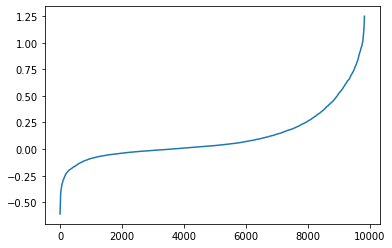

At cuttoff of 0.2  truepositive 45 truenegative 7659 falsepositive 2614 falsenegative 7 Accuracy 74.61501210653753 %
At cuttoff of 0.3  truepositive 42 truenegative 8418 falsepositive 1855 falsenegative 10 Accuracy 81.93704600484261 %
At cuttoff of 0.4  truepositive 40 truenegative 8891 falsepositive 1382 falsenegative 12 Accuracy 86.49878934624698 %
At cuttoff of 0.5  truepositive 38 truenegative 9259 falsepositive 1014 falsenegative 14 Accuracy 90.04358353510897 %
At cuttoff of 0.6  truepositive 37 truenegative 9558 falsepositive 715 falsenegative 15 Accuracy 92.92978208232445 %
At cuttoff of 0.7  truepositive 31 truenegative 9792 falsepositive 481 falsenegative 21 Accuracy 95.13801452784503 %
At cuttoff of 0.75  truepositive 30 truenegative 9877 falsepositive 396 falsenegative 22 Accuracy 95.95157384987894 %
At cuttoff of 0.8  truepositive 26 truenegative 9957 falsepositive 316 falsenegative 26 Accuracy 96.68765133171912 %
At cuttoff of 0.9  truepositive 15 truenegative 10101 falsep

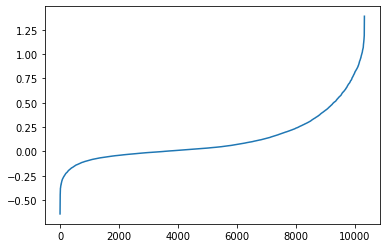


test sets-model_old
At cuttoff of 0.2  truepositive 25 truenegative 7578 falsepositive 2218 falsenegative 1 Accuracy 77.40785990633272 %
At cuttoff of 0.3  truepositive 24 truenegative 8190 falsepositive 1606 falsenegative 2 Accuracy 83.62858888210141 %
At cuttoff of 0.4  truepositive 24 truenegative 8611 falsepositive 1185 falsenegative 2 Accuracy 87.91488495214824 %
At cuttoff of 0.5  truepositive 21 truenegative 8940 falsepositive 856 falsenegative 5 Accuracy 91.23396456933415 %
At cuttoff of 0.6  truepositive 20 truenegative 9181 falsepositive 615 falsenegative 6 Accuracy 93.67745876603543 %
At cuttoff of 0.7  truepositive 19 truenegative 9393 falsepositive 403 falsenegative 7 Accuracy 95.82569741396864 %
At cuttoff of 0.75  truepositive 17 truenegative 9486 falsepositive 310 falsenegative 9 Accuracy 96.7521889635512 %
At cuttoff of 0.8  truepositive 16 truenegative 9551 falsepositive 245 falsenegative 10 Accuracy 97.40378741600489 %
At cuttoff of 0.9  truepositive 14 truenegative

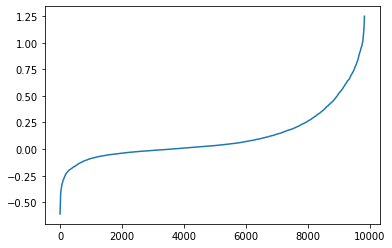

At cuttoff of 0.2  truepositive 45 truenegative 7659 falsepositive 2614 falsenegative 7 Accuracy 74.61501210653753 %
At cuttoff of 0.3  truepositive 42 truenegative 8418 falsepositive 1855 falsenegative 10 Accuracy 81.93704600484261 %
At cuttoff of 0.4  truepositive 40 truenegative 8891 falsepositive 1382 falsenegative 12 Accuracy 86.49878934624698 %
At cuttoff of 0.5  truepositive 38 truenegative 9259 falsepositive 1014 falsenegative 14 Accuracy 90.04358353510897 %
At cuttoff of 0.6  truepositive 37 truenegative 9558 falsepositive 715 falsenegative 15 Accuracy 92.92978208232445 %
At cuttoff of 0.7  truepositive 31 truenegative 9792 falsepositive 481 falsenegative 21 Accuracy 95.13801452784503 %
At cuttoff of 0.75  truepositive 30 truenegative 9877 falsepositive 396 falsenegative 22 Accuracy 95.95157384987894 %
At cuttoff of 0.8  truepositive 26 truenegative 9957 falsepositive 316 falsenegative 26 Accuracy 96.68765133171912 %
At cuttoff of 0.9  truepositive 15 truenegative 10101 falsep

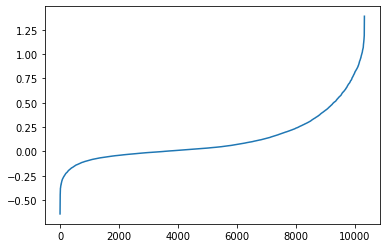

'\n\nprint("test sets-model2")\nevaluatedatasetlookahead(gru_model2,originaldata1)\nevaluatedatasetlookahead(gru_model2,originaldata2)\nprint("")\n\nprint("test sets-model3")\nevaluatedatasetlookahead(gru_model3,originaldata1)\nevaluatedatasetlookahead(gru_model3,originaldata2)\nprint("")\n\nprint("test sets-model4")\nevaluatedatasetlookahead(gru_model4,originaldata1)\nevaluatedatasetlookahead(gru_model4,originaldata2)\nprint("")\n'

In [16]:
device = torch.device("cpu")
#device = torch.device("cuda")
"""

print("Training sets")
originaldata=pd.read_csv('forcetorquebuttonresults_renormalized_10_04_2021_newrange.csv')#.head()
evaluatedatasetlookahead(gru_model1,originaldata)
print("")

originaldata=pd.read_csv('forcetorquebuttonresults_renormalized_10_06_2021_newrange.csv')#.head()
evaluatedatasetlookahead(gru_model1,originaldata)
print("")


originaldata=pd.read_csv('forcetorquebuttonresults_10_13_2021.csv')
evaluatedatasetlookahead(gru_model1,originaldata)

print("")
"""

print("test sets-model1")
originaldata1=pd.read_csv('forcetorquebuttonresults_cylinder_withbutton_train_noposeobs_GRUrewards_10-4_13-2021GRU_lookahead10_23_2021.csv')#.head()
evaluatedatasetlookahead(gru_model1,originaldata1)
originaldata2=pd.read_csv('forcetorquebuttonresults_cylinder_withbutton_train_noposeobs_GRUrewards_10-4_13-2021GRU_lookahead_pos2rewardifbuttonpress10_23_2021.csv')#.head()
evaluatedatasetlookahead(gru_model1,originaldata2)
print("")

print("test sets-model_old")
originaldata1=pd.read_csv('forcetorquebuttonresults_cylinder_withbutton_train_noposeobs_GRUrewards_10-4_13-2021GRU_lookahead10_23_2021.csv')#.head()
evaluatedatasetlookahead(gru_model_old,originaldata1)
originaldata2=pd.read_csv('forcetorquebuttonresults_cylinder_withbutton_train_noposeobs_GRUrewards_10-4_13-2021GRU_lookahead_pos2rewardifbuttonpress10_23_2021.csv')#.head()
evaluatedatasetlookahead(gru_model_old,originaldata2)
print("")

"""

print("test sets-model2")
evaluatedatasetlookahead(gru_model2,originaldata1)
evaluatedatasetlookahead(gru_model2,originaldata2)
print("")

print("test sets-model3")
evaluatedatasetlookahead(gru_model3,originaldata1)
evaluatedatasetlookahead(gru_model3,originaldata2)
print("")

print("test sets-model4")
evaluatedatasetlookahead(gru_model4,originaldata1)
evaluatedatasetlookahead(gru_model4,originaldata2)
print("")
"""


test set
At cuttoff of 0.2  truepositive 749 truenegative 9776 falsepositive 5326 falsenegative 121 Accuracy 65.89656899574256 %
At cuttoff of 0.3  truepositive 685 truenegative 11179 falsepositive 3923 falsenegative 185 Accuracy 74.27998998246932 %
At cuttoff of 0.4  truepositive 627 truenegative 12180 falsepositive 2922 falsenegative 243 Accuracy 80.18407212622088 %
At cuttoff of 0.5  truepositive 564 truenegative 12951 falsepositive 2151 falsenegative 306 Accuracy 84.6168294515402 %
At cuttoff of 0.6  truepositive 516 truenegative 13535 falsepositive 1567 falsenegative 354 Accuracy 87.97270222890057 %
At cuttoff of 0.7  truepositive 450 truenegative 14003 falsepositive 1099 falsenegative 420 Accuracy 90.48960681192086 %
At cuttoff of 0.75  truepositive 387 truenegative 14194 falsepositive 908 falsenegative 483 Accuracy 91.29100926621588 %
At cuttoff of 0.8  truepositive 345 truenegative 14349 falsepositive 753 falsenegative 525 Accuracy 91.9984973703982 %
At cuttoff of 0.9  trueposi

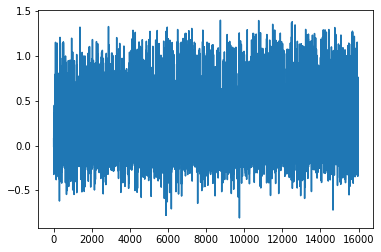

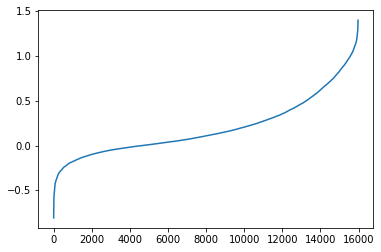

In [20]:
print("test set")
originaldata=pd.read_csv('forcetorquebuttonresults_renormalized_10_06_2021_newrange.csv')#.head()
evaluatedataset(gru_model3,originaldata,cutofflist=[0.2,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.9,1.0, 1.05,1.1,1.2,1.3,1.4])
print("")

In [117]:
originaldata=pd.read_csv('forcetorquebuttonresults_cylindernobutton_10_19_2021.csv')
print(originaldata.shape)

(5454, 30)


At cuttoff of 0.2  truepositive 310 truenegative 13501 falsepositive 1986 falsenegative 0 Accuracy 87.42799265683358 %
At cuttoff of 0.3  truepositive 310 truenegative 14144 falsepositive 1343 falsenegative 0 Accuracy 91.4983857694499 %
At cuttoff of 0.4  truepositive 310 truenegative 14530 falsepositive 957 falsenegative 0 Accuracy 93.94188770019623 %
At cuttoff of 0.5  truepositive 310 truenegative 14813 falsepositive 674 falsenegative 0 Accuracy 95.73336709501804 %
At cuttoff of 0.6  truepositive 309 truenegative 14999 falsepositive 488 falsenegative 1 Accuracy 96.90447553332912 %
At cuttoff of 0.7  truepositive 308 truenegative 15132 falsepositive 355 falsenegative 2 Accuracy 97.74007722985377 %
At cuttoff of 0.75  truepositive 305 truenegative 15177 falsepositive 310 falsenegative 5 Accuracy 98.0059504969298 %
At cuttoff of 0.8  truepositive 304 truenegative 15228 falsepositive 259 falsenegative 6 Accuracy 98.32246629106793 %
At cuttoff of 0.9  truepositive 298 truenegative 15320 

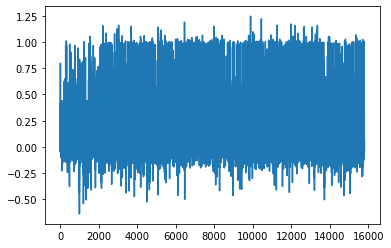

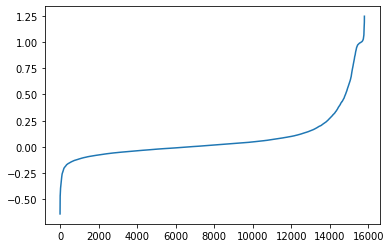

In [143]:
originaldata=pd.read_csv('forcetorquebuttonresults_cylindernobutton_10_19_2021.csv')
evaluatedataset(gru_model3,originaldata)

print("")


In [139]:
 (310+13501)/(310+13501+1986)

0.8742799265683358

In [136]:
row=897

headers=[]
for i in range(30):  
    label=str(i)
    headers.append("header"+label)

choppedheaders=[]
lookback=10 #save only the last 11 timesteps
for i in range(10):  
    label=str(i)
    choppedheaders.append("header"+label)

okcounter=0
for i in range(20):
    classifytest=originaldata[headers[i:10+i]].iloc[row*6:(row*6)+5].to_numpy()
    #print(classifytest)
    labelstest=originaldata[headers[i:10+i]].iloc[(row*6)+5].to_numpy()
    print(labelstest)
    #print(classifytest)
    classifytest=np.expand_dims(classifytest, axis=0)
    #print(classifytest.shape)
    #print(labelstest)

    outputfull=evaluate_episode(gru_model3, classifytest)

    #print("")

    #print("evaluating 1st timestep repeated 10 times")


    #print("prediction from 1 timestep",float(outputpartial),"actual",test_y[randomindex])
    
    if abs(float(outputfull)-labelstest[9])>0.3:
        result="X"
    else:
        result="OK"
        okcounter+=1
    print("prediction from timestep",i,"-",i+10," :",float(outputfull),"actual",labelstest[9], result)
print("okcounter",okcounter)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
prediction from timestep 0 - 10  : -0.008711494505405426 actual 0.0 OK
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
prediction from timestep 1 - 11  : 0.003979824483394623 actual 0.0 OK
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
prediction from timestep 2 - 12  : -0.01775369793176651 actual 0.0 OK
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
prediction from timestep 3 - 13  : 0.2741720378398895 actual 0.0 OK
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
prediction from timestep 4 - 14  : 0.1268426775932312 actual 0.0 OK
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
prediction from timestep 5 - 15  : 0.24690017104148865 actual 0.0 OK
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
prediction from timestep 6 - 16  : -0.008548252284526825 actual 0.0 OK
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
prediction from timestep 7 - 17  : -0.055137209594249725 actual 0.0 OK
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
prediction from timestep 8 - 18  : 0.06283382326364517 actual 0.0 OK
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
prediction from timestep 9 - 19  : 0.0840025767683982